In [195]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [831]:
import torch
import numpy as np
import matplotlib.pyplot as plt

ttype = torch.cuda.DoubleTensor if torch.cuda.is_available() else torch.DoubleTensor
torch.set_default_tensor_type(ttype)

from nonlinear_env import Nonlinear
from util import simulate, train_model, eval_model
from controllers import LinearController

In [832]:
def plot_stability(controller, env, N):
    controller.reset()
    obs = [env.reset()]

    for _ in range(N):
        u = controller(obs[-1])
        obs += [env.step(u)[0]]
    obs = torch.stack(obs).mean(dim=1).detach().cpu().numpy()
    print(obs[-1])
    plt.plot(np.arange(len(obs)), obs)

tensor([[9.6876e-01, 4.4371e-01],
        [6.5107e-02, 8.8245e-01],
        [7.7613e-01, 6.0546e-01],
        [1.5447e-01, 3.6967e-01],
        [8.0238e-01, 5.9725e-01],
        [7.6516e-01, 9.0193e-01],
        [4.5319e-01, 2.9595e-01],
        [7.9636e-01, 5.1602e-01],
        [4.1919e-01, 5.4561e-01],
        [2.0689e-01, 9.9076e-02],
        [6.6333e-01, 1.9622e-01],
        [3.3400e-01, 4.4979e-01],
        [2.8699e-04, 5.1101e-01],
        [5.4940e-01, 1.6561e-01],
        [4.1206e-01, 4.8341e-01],
        [3.9169e-02, 2.0533e-02],
        [4.2147e-01, 9.0865e-01],
        [9.0025e-01, 8.7033e-01],
        [9.2017e-01, 4.4789e-01],
        [8.3718e-01, 5.1178e-01],
        [7.8626e-01, 8.2239e-01],
        [6.8791e-01, 7.6845e-01],
        [3.2892e-01, 5.1763e-01],
        [5.8100e-01, 7.0543e-01],
        [2.7993e-01, 9.1807e-01],
        [2.2140e-01, 4.4458e-01],
        [6.3702e-02, 1.3463e-01],
        [6.6186e-01, 4.5735e-02],
        [1.7875e-01, 7.9573e-01],
        [8.556

tensor([[ 1.4645e-01],
        [-1.7270e+22],
        [ 1.4231e-01],
        [ 1.4229e-01],
        [ 1.4237e-01],
        [-3.2761e+25],
        [ 1.4229e-01],
        [ 1.4236e-01],
        [ 1.4229e-01],
        [ 1.4229e-01],
        [ 1.4230e-01],
        [ 1.4229e-01],
        [ 1.4229e-01],
        [ 1.4229e-01],
        [ 1.4229e-01],
        [ 1.4229e-01],
        [-1.0663e+36],
        [ 1.4645e-01],
        [ 1.4645e-01],
        [ 1.4645e-01],
        [ 1.4185e-01],
        [ 1.4226e-01],
        [ 1.4229e-01],
        [ 1.4228e-01],
        [-6.7347e+41],
        [ 1.4229e-01],
        [ 1.4229e-01],
        [ 1.4230e-01],
        [ 1.4198e-01],
        [ 1.4645e-01],
        [ 1.4645e-01],
        [ 1.4218e-01],
        [ 1.4229e-01],
        [-3.7025e+18],
        [ 1.4645e-01],
        [ 1.4228e-01],
        [ 1.4230e-01],
        [ 1.4229e-01],
        [ 1.4229e-01],
        [ 1.4645e-01],
        [ 1.4229e-01],
        [ 1.4225e-01],
        [ 1.4200e-01],
        [ 1

tensor([[         nan],
        [         nan],
        [  1.4229e-01],
        [  1.4229e-01],
        [  1.4229e-01],
        [         nan],
        [  1.4229e-01],
        [  1.4229e-01],
        [  1.4229e-01],
        [  1.4229e-01],
        [  1.4229e-01],
        [  1.4229e-01],
        [  1.4229e-01],
        [  1.4229e-01],
        [  1.4229e-01],
        [  1.4229e-01],
        [         nan],
        [         nan],
        [         nan],
        [         nan],
        [  1.4229e-01],
        [  1.4229e-01],
        [  1.4229e-01],
        [  1.4229e-01],
        [         nan],
        [  1.4229e-01],
        [  1.4229e-01],
        [  1.4229e-01],
        [  1.4229e-01],
        [         nan],
        [         nan],
        [  1.4229e-01],
        [  1.4229e-01],
        [         nan],
        [         nan],
        [  1.4229e-01],
        [  1.4229e-01],
        [  1.4229e-01],
        [  1.4229e-01],
        [         nan],
        [  1.4229e-01],
        [  1.422

tensor([[   nan],
        [   nan],
        [0.1423],
        [0.1423],
        [0.1423],
        [   nan],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [   nan],
        [   nan],
        [   nan],
        [   nan],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [   nan],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [   nan],
        [   nan],
        [0.1423],
        [0.1423],
        [   nan],
        [   nan],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [   nan],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [   nan],
        [0.1423],
        [   nan],
        [0.1423],
        [0.1423],
        [0.1423],
        [0

tensor([[   nan],
        [   nan],
        [0.1423],
        [0.1423],
        [0.1423],
        [   nan],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [   nan],
        [   nan],
        [   nan],
        [   nan],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [   nan],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [   nan],
        [   nan],
        [0.1423],
        [0.1423],
        [   nan],
        [   nan],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [   nan],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [0.1423],
        [   nan],
        [0.1423],
        [   nan],
        [0.1423],
        [0.1423],
        [0.1423],
        [0

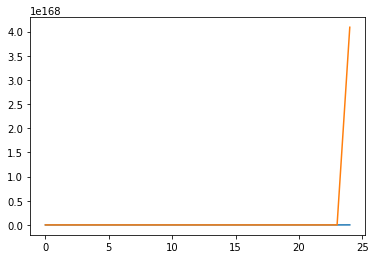

In [856]:
batch_size = 128
n_layers = 0
dim_hidden = 2
learning_rate = 1e-2

# System Dynamics
A = lambda x: torch.eye(2).view(1, 2, 2).repeat(batch_size, 1, 1)
B = lambda x: torch.tensor([0., 1.]).view(1, 2, 1).repeat(batch_size, 1, 1)
Z = lambda x: torch.stack([x[:, 1], x[:, 0] ** 2]).t()
C1 = lambda x: torch.stack([x[:, 1], -x[:, 0], torch.zeros_like(x[:, 1]), -x[:, 1]]).view(2, 2, batch_size).permute(2, 0, 1)
C2 = lambda x: torch.stack([-torch.ones_like(x[:, 0]), x[:, 0]]).view(1, 2, batch_size).permute(2, 0, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

controller = LinearController(2, 1, dim_h=dim_hidden, hidden=n_layers).to(device)
env = Nonlinear(A, B, Z, C1, C2, batch_size=batch_size)
opt = torch.optim.Adam(controller.parameters(), lr=learning_rate)
controller.init_weights()

loss = simulate(controller, env, n_steps)
print(loss.mean())

plot_stability(controller, env, 100)

In [857]:
import copy

starting = copy.deepcopy(controller.state_dict())

In [864]:
n_epochs = 200
n_steps = 100

controller.load_state_dict(starting)

losses = train_model(controller, env, opt, n_epochs, n_steps, noise=0.05)

tensor([[0.2611, 0.0146, 0.3873,  ..., 0.3448, 1.7272, 0.6399],
        [0.9401, 0.0490, 0.0208,  ..., 0.0157, 2.8853, 0.1036],
        [0.3139, 0.0098, 0.2949,  ..., 0.2049, 3.8428, 0.5998],
        ...,
        [   nan, 0.0174, 0.0160,  ..., 0.0367,    nan, 0.0236],
        [   nan, 0.0233, 0.0234,  ..., 0.0282,    nan, 0.0357],
        [   nan, 0.0266, 0.0426,  ..., 0.0190,    nan, 0.0132]],
       grad_fn=<NegBackward>)
tensor([[0.0024, 0.5531, 1.1342,  ..., 0.0102, 0.8459, 0.2388],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan]],
       grad_fn=<NegBackward>)
tensor([[1.1453e-01, 7.6989e-01, 7.2503e-01,  ..., 2.8346e-04, 1.6189e-01,
         5.8994e-03],
        [       nan,        nan,        nan,  .

tensor([[0.0221, 0.6453, 0.4835,  ..., 0.8423, 0.3160, 0.2438],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan]],
       grad_fn=<NegBackward>)
tensor([[0.0016, 1.3805, 0.0421,  ..., 0.0181, 0.6123, 1.1768],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan]],
       grad_fn=<NegBackward>)
tensor([[0.2926, 0.0072, 0.2729,  ..., 0.0134, 0.2866, 0.3297],
        [   nan,    nan,    nan,  ...,    nan,    nan,    nan],
        [   nan,

KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.xlabel('epochs')
plt.ylabel('mean_loss')
plt.show()

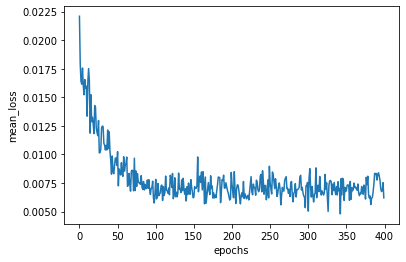

In [826]:
n_epochs = 200
n_steps = 100

losses = train_model(controller, env, opt, n_epochs, n_steps, v=False)
plt.plot(np.arange(len(losses)), losses)
plt.xlabel('epochs')
plt.ylabel('mean_loss')
plt.show()

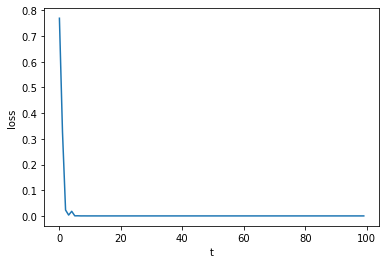

[0.0038766  0.00387658]


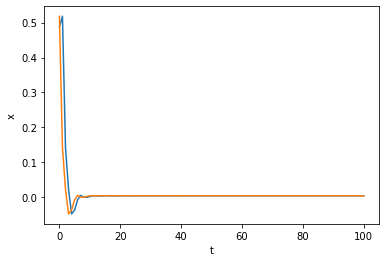

[Parameter containing:
tensor([[ 0.7890, -0.5176],
        [-0.0361, -0.1584]], requires_grad=True), Parameter containing:
tensor([[-1.0178,  0.0357]], requires_grad=True), Parameter containing:
tensor([0.0049], requires_grad=True)]


In [829]:
sim_loss = simulate(controller, env, 100)[:, 0].detach().cpu().numpy()
plt.plot(np.arange(len(sim_loss)), sim_loss)
plt.xlabel('t')
plt.ylabel('loss')
plt.show()

plot_stability(controller, env, 100)
plt.xlabel('t')
plt.ylabel('x')
plt.show()
print(list(controller.parameters()))